# **Non-ML User Segmentation for TravelTide: Rule-Based Clustering & Perk Assignment**


This **non_ml_segmentation.ipynb** notebook implements a **rule-based, non-machine learning approach** to segment users in the **TravelTide cluster**. It uses business logic, thresholds, and predefined rules to create actionable user segments and assign personalized perks.

The notebook leverages modules for data management, metric calculation, segmentation, perk assignment, and visualization to deliver transparent, interpretable, and actionable user groups.



## **Description:**

This **non_ml_segmentation.ipynb** notebook implements a **rule-based, non-machine learning approach** to segment users in the **TravelTide cluster**. It uses **dynamic thresholds, quantile-based logic, and business rules** to create actionable user segments and assign personalized perks.

#### **Segmentation Logic & Rules:**
The segmentation is driven by **quantile-based thresholds** (80th percentile) with fallback values to ensure robustness, even with sparse data. The rules are defined as follows:

- **TOTAL_SPEND**: Users with spending ≥ **80th percentile (~5522)** or **fallback 4000** qualify as top spenders.
- **TRIP_COUNT**: Users with ≥ **4 trips (80th percentile)** or **fallback 1.5 trips** are frequent travelers.
- **BROWSING_RATE**: Users with a browsing rate ≥ **0.78 (80th percentile)** or **fallback 0.6** are high-intent browsers.
- **HOTEL_SPEND**: Users spending ≥ **2446 (80th percentile)** or **fallback 1200** on hotels are heavy hotel spenders.
- **BUSINESS_RATE**: Users with a business travel rate ≥ **0.33 (80th percentile)** or **fallback 0.2** are business travelers.
- **GROUP_RATE**: Users with a group travel rate ≥ **0.1 (fallback)** are occasional group travelers.
- **AVG_BAGS**: Users with ≥ **1.0 average bags (80th percentile)** are heavy baggage users.

#### **User Groups & Perks:**
Users are assigned to **five distinct groups** based on their behavior:
1. **VIP High-Frequency Spenders**: "1 night free hotel plus flight"
2. **High-Intent Browsers & Spenders**: "No cancellation fees"
3. **Group & Family Travelers / Heavy Baggage**: "Free checked bags"
4. **Hotel & Business Focused Travelers**: "Free hotel meal"
5. **Baseline Travelers**: "Exclusive discounts"



In [10]:
import sys, os  # noqa: E401

# --- Setup ---
%load_ext autoreload
%autoreload 2
%matplotlib inline

bad_paths = [
    "/Users/guykaptue/my_work_spaces/machine learning",
    "/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src"
]
sys.path = [p for p in sys.path if os.path.abspath(p) not in bad_paths]

print("Clean sys.path:")
for p in sys.path:
    print(" -", p)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Clean sys.path:
 - /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/notebooks
 - /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/notebooks
 - /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project
 - /opt/anaconda3/envs/ml311/lib/python311.zip
 - /opt/anaconda3/envs/ml311/lib/python3.11
 - /opt/anaconda3/envs/ml311/lib/python3.11/lib-dynload
 - 
 - /opt/anaconda3/envs/ml311/lib/python3.11/site-packages
 - __editable__.tts_mastery_project-0.1.0.finder.__path_hook__


In [11]:
import pandas as pd  # noqa: F401
import numpy as np  # noqa: F401
from IPython.display import display

# ------------------------------------------------------------
# 1️⃣ Determine project root dynamically
# - Works even if notebook is in a subfolder of notebooks/
# ------------------------------------------------------------
cwd = os.getcwd()
print("Current working directory:", cwd)

# Project root = traveltide_project folder
# Assumes notebooks/ is directly under traveltide_project/
project_root = os.path.abspath(os.path.join(cwd, "..", "..", ".."))
print("Project root:", project_root)

## ------------------------------------------------------------
# 2️⃣ Add project root to sys.path for imports
# ------------------------------------------------------------
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)

print(sys.path)  # Ensure /traveltide_project is included

# Check if src exists
print(os.path.exists(os.path.join(project_root, "src")))


Current working directory: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/notebooks/segments/non_ml
Project root: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project
Project root added to sys.path: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project
['/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/notebooks', '/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/notebooks', '/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project', '/opt/anaconda3/envs/ml311/lib/python311.zip', '/opt/anaconda3/envs/ml311/lib/python3.11', '/opt/anaconda3/envs/ml311/lib/python3.11/lib-dynload', '', '/opt/anaconda3/envs/ml311/lib/python3.11/site-packages', '__editable__.tts_mastery_project-0.1.0.finder.__path_hook__']
True


In [12]:
# Verify that src is importable
try:
    import src
    print("✅ src module found at:", src.__file__)
except ModuleNotFoundError:
    print("❌ src module not found. Check your sys.path!")

✅ src module found at: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src/__init__.py


In [13]:
from src.core import (
    DataLoader, # noqa: F401
    NonMachineLearningSegment
) 

In [14]:
loader = DataLoader()

users = loader.load_table(data_type='feature', table_name='user_base')

✅ Verbindung zur PostgreSQL-Datenbank hergestellt.
📁 Lade Tabelle 'user_base' aus CSV: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/data/csv/processed/features/user_base.csv
✅ CSV geladen. Zeilen: 5998


In [15]:
users.columns

Index(['user_id', 'num_clicks', 'avg_session_clicks', 'max_session_clicks',
       'num_empty_sessions', 'num_canceled_trips', 'num_sessions',
       'avg_session_duration', 'num_trips', 'num_destinations', 'num_flights',
       'num_hotels', 'num_group_trips', 'num_pair_trips', 'num_business_trips',
       'num_weekend_trips_agg', 'num_discount_trips_agg',
       'money_spent_hotel_total', 'avg_money_spent_flight',
       'avg_money_spent_hotel_trip', 'avg_money_spent_per_seat',
       'avg_km_flown', 'avg_bags', 'international_ratio',
       'avg_time_after_booking', 'avg_trip_length', 'num_season_fall',
       'num_season_spring', 'num_season_summer', 'num_season_unknown',
       'num_season_winter', 'booking_growth', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'age',
       'global_booking_share', 'persona_type', 'avg_dollars_saved_per_km',
       'bargain_hunter_index', 'num_browsing_sessions',
       'avg_browsing_duration', 'total_browsing_clicks', '

In [16]:
# Example of preparing the DataFrame
users['total_spend'] = users['money_spent_hotel_total'] + (users['avg_money_spent_flight'] * users['num_flights'])
users['browsing_rate'] = users['num_empty_sessions'] / users['num_sessions']
users['business_rate'] = users['num_business_trips'] / users['num_trips']
users['group_rate'] = users['num_group_trips'] / users['num_trips']
users['weekend_ratio'] = users['num_weekend_trips_agg'] / users['num_trips']
# Add other required columns similarly

In [17]:
segment = NonMachineLearningSegment(users=users)

✅ Loaded YAML: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/config/non_ml_config.yaml
✅ Configuration loaded successfully
✅ NonMachineLearningSegment initialized
   - Total users: 5,998
   - Data output: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/data/csv/processed/segment/non_ml
   - Fig output: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/segment/non_ml
   - Config: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/config/non_ml_config.yaml



🚀 CUSTOMER SEGMENTATION PIPELINE

[STEP 1] Computing intermediate metrics...
   ➡️ Added cancellation_rate
   ➡️ Computed browsing_rate
   ➡️ Computed group_rate
   ➡️ Computed business_rate
   ➡️ Computed total_spend
✅ Intermediate metrics complete
[STEP 2] Calculating quantile thresholds from configuration...
   ➡️ TOTAL_SPEND: 5606.480 (quantile 0.8)
      📝 Spend median ≈ 3343, mean ≈ 4179, 75% ≈ 5522. Using the 80th percentile (~5522) ...
   ➡️ TRIP_COUNT: 4.000 (quantile 0.8)
      📝 Trips median = 3, mean ≈ 2.68. Setting quantile at 0.8 (~4 trips) with fallback ...
   ➡️ BROWSING_RATE: 0.875 (quantile 0.8)
      📝 Browsing rate mean ≈ 0.66, median ≈ 0.625. Threshold at 0.8 (~0.78) captures hig...
   ➡️ HOTEL_SPEND: 2733.880 (quantile 0.8)
      📝 Hotel spend median ≈ 1213, mean ≈ 1831. 80th percentile (~2446) targets heavy ho...
   ➡️ BUSINESS_RATE: 0.333 (quantile 0.8)
      📝 Business rate mean ≈ 0.19, median = 0.0. 80th percentile (~0.33) captures busine...
   ➡️ GROUP_RATE:

INFO:choreographer.browsers.chromium:Chromium init'ed with kwargs {}
INFO:choreographer.browsers.chromium:Found chromium path: /Applications/Google Chrome.app/Contents/MacOS/Google Chrome
INFO:choreographer.utils._tmpfile:Temp directory created: /var/folders/ml/gbzd550j28bfftvz5yhp9gf40000gn/T/tmp3444f9sy.
INFO:choreographer.browser_async:Opening browser.
INFO:choreographer.utils._tmpfile:Temp directory created: /var/folders/ml/gbzd550j28bfftvz5yhp9gf40000gn/T/tmpy634nhhp.
INFO:choreographer.browsers.chromium:Temporary directory at: /var/folders/ml/gbzd550j28bfftvz5yhp9gf40000gn/T/tmpy634nhhp


📊 HTML saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/segment/non_ml/html/segment_summary_table.html


INFO:kaleido.kaleido:Conforming 1 to file:///var/folders/ml/gbzd550j28bfftvz5yhp9gf40000gn/T/tmp3444f9sy/index.html
INFO:kaleido.kaleido:Waiting on all navigates
INFO:kaleido.kaleido:All navigates done, putting them all in queue.
INFO:kaleido.kaleido:Getting tab from queue (has 1)
INFO:kaleido.kaleido:Got 5EC6
INFO:kaleido._kaleido_tab:Processing Segment_Summary_with_Perks.png
INFO:kaleido._kaleido_tab:Sending big command for Segment_Summary_with_Perks.png.
INFO:kaleido._kaleido_tab:Sent big command for Segment_Summary_with_Perks.png.
INFO:kaleido.kaleido:Reloading tab 5EC6 before return.
INFO:kaleido.kaleido:Putting tab 5EC6 back (queue size: 0).
INFO:kaleido.kaleido:Waiting for all cleanups to finish.
INFO:kaleido.kaleido:Exiting Kaleido
INFO:choreographer.browser_async:Closing browser.
INFO:choreographer.browser_async:Closing browser.
INFO:choreographer.utils._tmpfile:TemporaryDirectory.cleanup() worked.
INFO:choreographer.utils._tmpfile:shutil.rmtree worked.
INFO:kaleido.kaleido:Ca

🖼 PNG saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/segment/non_ml/segment_summary_table.png


INFO:choreographer.utils._tmpfile:TemporaryDirectory.cleanup() worked.
INFO:choreographer.utils._tmpfile:shutil.rmtree worked.


[VISUALIZATION] Creating perk distribution plot...
   ✅ Saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/segment/non_ml/perk_distribution_plot.png


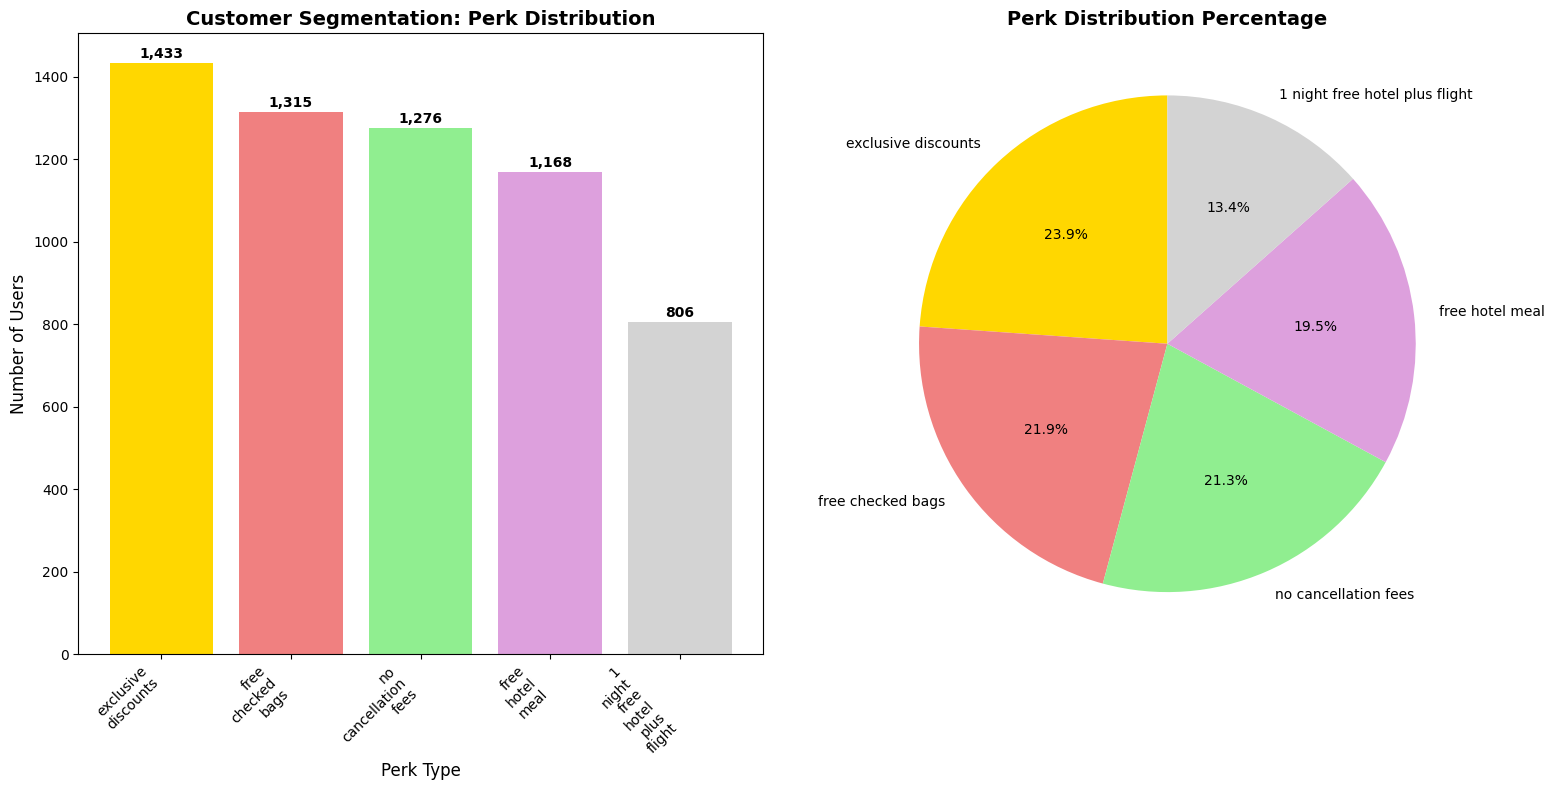

[VISUALIZATION] Creating threshold coverage plot...
   ✅ Saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/segment/non_ml/threshold_coverage.png
[VISUALIZATION] Creating decision tree...


/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src/core/segment/non_ml/visualizer.py:257: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src/core/segment/non_ml/visualizer.py:315: UserWarning:

Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.

/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src/core/segment/non_ml/visualizer.py:315: UserWarning:

Glyph 127890 (\N{SCHOOL SATCHEL}) missing from font(s) DejaVu Sans.

/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src/core/segment/non_ml/visualizer.py:315: UserWarning:

Glyph 127976 (\N{HOTEL}) missing from font(s) DejaVu Sans.

/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src/core/segment/non_ml/visualizer.py:315: UserWarning:

Glyph 128737 (\N{SHIELD}) missing from font(s) Deja

   ✅ Saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/segment/non_ml/decision_tree.png

🎉 PIPELINE COMPLETE!
   - VIP High-Frequency Spenders: 806 users (13.4%)
   - Baseline Travelers: 1,433 users (23.9%)
   - Group & Family Travelers / Heavy Baggage: 1,315 users (21.9%)
   - Hotel & Business Focused Travelers: 1,168 users (19.5%)
   - High-Intent Browsers & Spenders: 1,276 users (21.3%)


/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src/core/segment/non_ml/visualizer.py:321: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



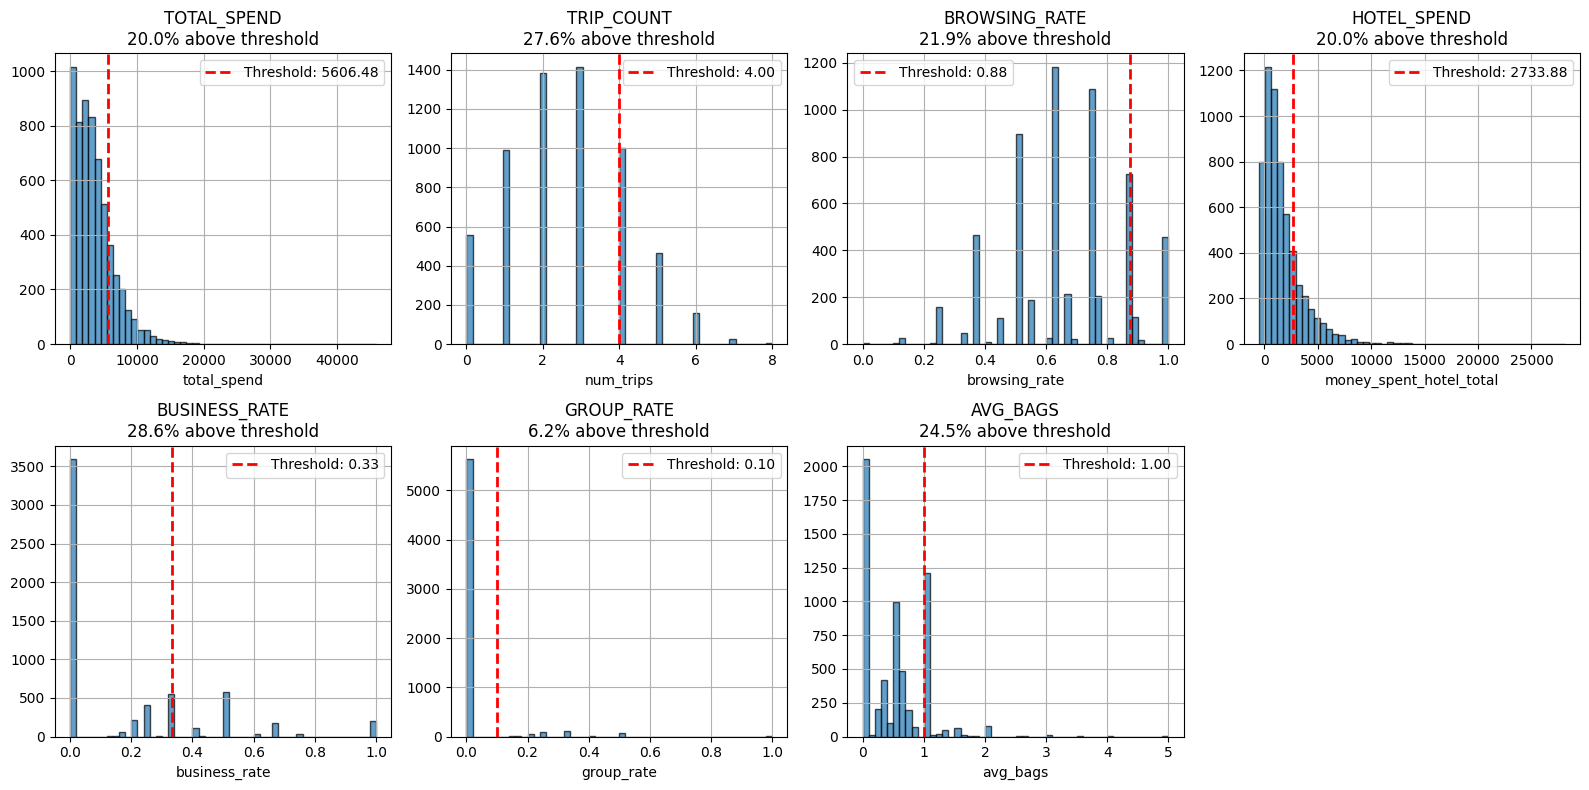

/opt/anaconda3/envs/ml311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ml311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 127890 (\N{SCHOOL SATCHEL}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ml311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 127976 (\N{HOTEL}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/ml311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128737 (\N{SHIELD}) missing from font(s) DejaVu Sans.



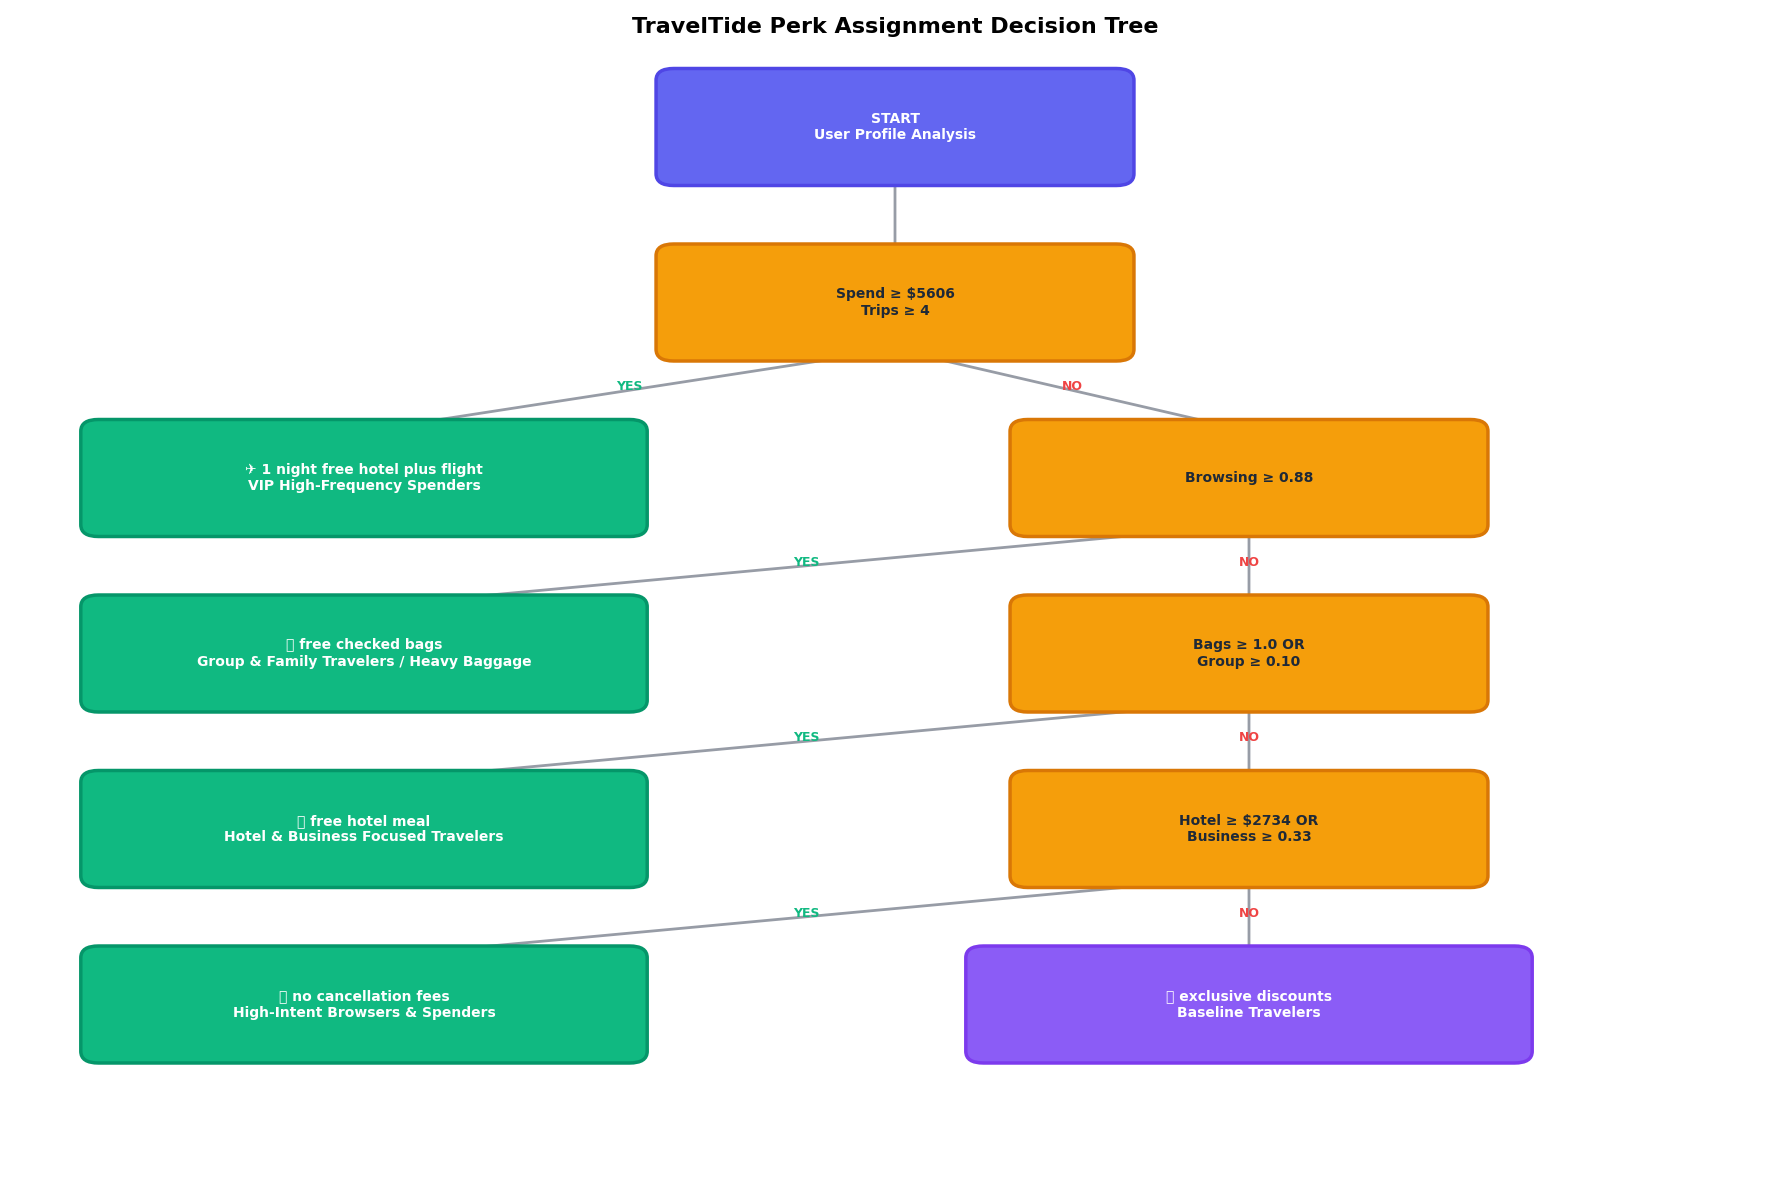

In [18]:
df, distribution, decision_tree= segment.run()



## 📊 Executive Interpretation of Segmentation Results

The TravelTide segmentation analysis processed **5,998 customers** and identified five distinct traveler segments. Each segment is defined by behavioral thresholds and assigned a tailored perk. The following summary highlights segment size, share of total users, and average value indicators.

---

### 1. VIP High-Frequency Spenders  
- **Assigned Perk:** 1 night free hotel plus flight  
- **Segment Size:** 806 customers  
- **Share of Total:** 13.4%  
- **Average Spend:** $8,372  
- **Average Trips:** 4.8  

This segment represents the highest-value customers. Although relatively small in size, their spending and travel frequency are significantly above average. They are critical for revenue concentration and loyalty initiatives.

---

### 2. Group & Family Travelers / Heavy Baggage  
- **Assigned Perk:** Free checked bags  
- **Segment Size:** 1,315 customers  
- **Share of Total:** 21.9%  
- **Average Spend:** $996  
- **Average Trips:** 0.7  

This group travels infrequently but often with higher logistical needs. Their lower spend is offset by their volume and potential for ancillary revenue. The assigned perk directly addresses their pain point.

---

### 3. Hotel & Business Focused Travelers  
- **Assigned Perk:** Free hotel meal  
- **Segment Size:** 1,168 customers  
- **Share of Total:** 19.5%  
- **Average Spend:** $3,934  
- **Average Trips:** 2.6  

These customers demonstrate consistent engagement with hotel services and business travel. Their spend and trip frequency position them as mid-tier contributors with potential for upselling into premium hotel packages.

---

### 4. High-Intent Browsers & Spenders  
- **Assigned Perk:** No cancellation fees  
- **Segment Size:** 1,276 customers  
- **Share of Total:** 21.3%  
- **Average Spend:** $3,985  
- **Average Trips:** 2.9  

This segment shows strong browsing activity and moderate spending. Flexibility is a key driver for conversion. The assigned perk reduces booking friction and supports higher conversion rates.

---

### 5. Baseline Travelers  
- **Assigned Perk:** Exclusive discounts  
- **Segment Size:** 1,433 customers  
- **Share of Total:** 23.9%  
- **Average Spend:** $2,843  
- **Average Trips:** 2.8  

This is the largest segment by volume. They are price-sensitive and respond well to discount-driven campaigns. While their average spend is lower, their scale makes them essential for sustaining overall revenue.

---

## 📈 Strategic Implications

- **Revenue Concentration:** VIP High-Frequency Spenders (13.4%) generate the highest average spend, underscoring the importance of retention and premium loyalty programs.  
- **Volume Segments:** Baseline Travelers (23.9%) and Group & Family Travelers (21.9%) represent nearly half of the customer base. Their engagement strategies should focus on retention and cost-effective perks.  
- **Conversion Levers:** High-Intent Browsers benefit most from flexibility incentives, while Hotel & Business Travelers respond to service enhancements.  
- **Balanced Portfolio:** The segmentation demonstrates a balanced distribution across high-value, mid-tier, and baseline groups, enabling differentiated marketing strategies.



In [19]:
df.columns

Index(['user_id', 'num_clicks', 'avg_session_clicks', 'max_session_clicks',
       'num_empty_sessions', 'num_canceled_trips', 'num_sessions',
       'avg_session_duration', 'num_trips', 'num_destinations', 'num_flights',
       'num_hotels', 'num_group_trips', 'num_pair_trips', 'num_business_trips',
       'num_weekend_trips_agg', 'num_discount_trips_agg',
       'money_spent_hotel_total', 'avg_money_spent_flight',
       'avg_money_spent_hotel_trip', 'avg_money_spent_per_seat',
       'avg_km_flown', 'avg_bags', 'international_ratio',
       'avg_time_after_booking', 'avg_trip_length', 'num_season_fall',
       'num_season_spring', 'num_season_summer', 'num_season_unknown',
       'num_season_winter', 'booking_growth', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'age',
       'global_booking_share', 'persona_type', 'avg_dollars_saved_per_km',
       'bargain_hunter_index', 'num_browsing_sessions',
       'avg_browsing_duration', 'total_browsing_clicks', '

In [20]:
distribution.columns

Index(['assigned_group', 'assigned_perk', 'Count', 'Percentage'], dtype='object')